In [1]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import *

import numpy as np
import pandas as pd
from IPython.display import display

import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tabulate import tabulate
import statistics as st
import random
import copy

import seaborn as sns

import time

import csv

In [2]:
def SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,       #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
    sensitivity_number = len(sensitivity_proportion)
    activity_number = len(contact_rate_proportion)
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = sensitivity_number * activity_number     # number of divisions
    c = np.zeros(division_number)          # contact rate
    p = np.zeros(division_number)          # proportion
    lambdas = np.zeros(division_number)          # lamda, Infection rate
    gammas = np.zeros(division_number)          # gamma, Exposed to infected rate
    sigma_Es = np.zeros(division_number)          # sigma_E, Recovery rate for exposed
    sigma_Is = np.zeros(division_number)          # sigma_I, Cured rate for infected
    deltas = np.zeros(division_number)          # delta, death rate (case fatality rate)

    for j in range(0,activity_number):
        for i in range(0,sensitivity_number):
            c[(j)*sensitivity_number+i] = contact_rate[j]
            p[(j)*sensitivity_number+i] = contact_rate_proportion[j]*sensitivity_proportion[i]
            lambdas[(j)*sensitivity_number+i] = infection_rate[i]
            gammas[(j)*sensitivity_number+i] = exposed_to_infected_rate[i]
            sigma_Es[(j)*sensitivity_number+i] = recovery_rate_for_exposed[i]
            sigma_Is[(j)*sensitivity_number+i] = cured_rate_for_infected[i]
            deltas[(j)*sensitivity_number+i] = death_rate[i]
        # end for i
    # end for j

# (2.1) Show all the parameters for each division (not be printed out)
    Sensitivity_Matrix = np.zeros((7, division_number))
    Sensitivity_Matrix[0] = p        ; Sensitivity_Matrix[1] = c      
    Sensitivity_Matrix[2] = lambdas  ; Sensitivity_Matrix[3] = gammas  
    Sensitivity_Matrix[4] = sigma_Es ; Sensitivity_Matrix[5] = sigma_Is
    Sensitivity_Matrix[6] = deltas 
    Sensitivity_Matrix_df = pd.DataFrame(Sensitivity_Matrix.T)
    colnames = ["Proportion","Contact rate","Infection rate","Exposed to infected","Recovery rate","Cured rate","Death rate"]
    Sensitivity_Matrix_df.columns = colnames
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = p * susceptible_population    
    E[0,:] = p * exposed_population    
    R[0,:] = p * recovered_population
    I[0,:] = p * infected_population
    C[0,:] = p * cured_population
    D[0,:] = p * deaded_population
    N[0,:] = p * N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 S[t-1], E[t-1], R[t-1], I[t-1], N[t-1], Immunized[t-1], 
                                 total_time_for_greedy)
        
        V[t-1] = v                        # Record vaccinated people in period t
        Immunized[t] = sum(V)     # Record total vaccinated people till time t

# (5.1.1) Determine vaccinated proportion for each division among S, E, R states, in case we have 0/(0 + 0 + 0)
    
        vaccinated_proportion_in_S = np.zeros(division_number)
        vaccinated_proportion_in_E = np.zeros(division_number)
        vaccinated_proportion_in_R = np.zeros(division_number)
        
        for k in range(0,division_number): 
            if S[t-1,k] == 0:
                vaccinated_proportion_in_S[k] = 0
            else:
                vaccinated_proportion_in_S[k] = S[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if E[t-1,k] == 0:
                vaccinated_proportion_in_E[k] = 0
            else:
                vaccinated_proportion_in_E[k] = E[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if R[t-1,k] == 0:
                vaccinated_proportion_in_R[k] = 0
            else:
                vaccinated_proportion_in_R[k] = R[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
        # end for k
    
                    
# (5.2) determine delta S for each division k
  
        for k in range(0,division_number): 
            if S[t-1,k] == 0:   # no more S people, dS will be 0.
                dS[t-1,k] = 0
            else:
                source = sum(c*(E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E)) # population contacted by exposed people
                dS[t-1,k] = min(lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
            # end if
        # end for k
        
# (5.3) SEIR change: S, E, R, I, C
    
        S[t] = S[t-1] - dS[t-1]                                    - vaccine_efficacy * v * vaccinated_proportion_in_S
        E[t] = E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E
        R[t] = R[t-1]           + sigma_Es*E[t-1]                  - vaccine_efficacy * v * vaccinated_proportion_in_R             
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        
        for k in range(0,division_number):        # in case the population decreases to negative
            S[t,k] = max(S[t,k], 0)   
            E[t,k] = max(E[t,k], 0)
            R[t,k] = max(R[t,k], 0)
        # end for k

# (5.4) Death occured in t-th period
    
        for k in range(0,division_number): 
            dD[t-1,k] = min(deltas[k]*I[t-1,k], N[t-1,k])
        # end for k
                                        
# (5.5) SEIR change: D, N  
        
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

    # end for t

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

In [3]:
def SEIR_simulation_division(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      # record population in each division
    exposed_population,          # record population in each division
    recovered_population,        # record population in each division
    infected_population,         # record population in each division
    cured_population,            # record population in each division
    deaded_population,           # record population in each division
        
# (1.2) contact rate & proportion
    contact_rate,                # record contact rate in each division
    contact_rate_proportion,     # not needed   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              # record for each division
    exposed_to_infected_rate,    # record for each division
    recovery_rate_for_exposed,   # record for each division
    cured_rate_for_infected,     # record for each division
    death_rate,                  # record for each division
    sensitivity_proportion,      # record for each division
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
#     sensitivity_number = len(sensitivity_proportion)
#     activity_number = len(contact_rate_proportion)
    total_population = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = len(contact_rate)     # number of divisions
    c = contact_rate         # contact rate
#     p = np.zeros(division_number)          # proportion
    lambdas = infection_rate          # lamda, Infection rate
    gammas = exposed_to_infected_rate          # gamma, Exposed to infected rate
    sigma_Es = recovery_rate_for_exposed          # sigma_E, Recovery rate for exposed
    sigma_Is = cured_rate_for_infected          # sigma_I, Cured rate for infected
    deltas = death_rate          # delta, death rate (case fatality rate)
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = susceptible_population    
    E[0,:] = exposed_population   
    R[0,:] = recovered_population 
    I[0,:] = infected_population
    C[0,:] = cured_population 
    D[0,:] = deaded_population  
    N[0,:] = total_population

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = sum(total_population)/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 S[t-1] , E[t-1] , R[t-1] , 
                                 I[t-1] , N[t-1] , Immunized[t-1], 
                                 total_time_for_greedy)
        
        V[t-1] = v                        # Record vaccinated people in period t
        Immunized[t] = sum(V)     # Record total vaccinated people till time t

# (5.1.1) Determine vaccinated proportion for each division among S, E, R states, in case we have 0/(0 + 0 + 0)
    
        vaccinated_proportion_in_S = np.zeros(division_number)
        vaccinated_proportion_in_E = np.zeros(division_number)
        vaccinated_proportion_in_R = np.zeros(division_number)
        
        for k in range(0,division_number): 
            if S[t-1,k] == 0:
                vaccinated_proportion_in_S[k] = 0
            else:
                vaccinated_proportion_in_S[k] = S[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if E[t-1,k] == 0:
                vaccinated_proportion_in_E[k] = 0
            else:
                vaccinated_proportion_in_E[k] = E[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if R[t-1,k] == 0:
                vaccinated_proportion_in_R[k] = 0
            else:
                vaccinated_proportion_in_R[k] = R[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
        # end for k
    
                    
# (5.2) determine delta S for each division k
  
        for k in range(0,division_number): 
            if S[t-1,k] == 0:   # no more S people, dS will be 0.
                dS[t-1,k] = 0
            else:
                source = sum(c*(E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E)) # population contacted by exposed people
                dS[t-1,k] = min(lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
            # end if
        # end for k
        
# (5.3) SEIR change: S, E, R, I, C
    
        S[t] = S[t-1] - dS[t-1]                                    - vaccine_efficacy * v * vaccinated_proportion_in_S
        E[t] = E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E
        R[t] = R[t-1]           + sigma_Es*E[t-1]                  - vaccine_efficacy * v * vaccinated_proportion_in_R             
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        
        for k in range(0,division_number):        # in case the population decreases to negative
            S[t,k] = max(S[t,k], 0)   
            E[t,k] = max(E[t,k], 0)
            R[t,k] = max(R[t,k], 0)
        # end for k

# (5.4) Death occured in t-th period
    
        for k in range(0,division_number): 
            dD[t-1,k] = min(deltas[k]*I[t-1,k], N[t-1,k])
        # end for k
                                        
# (5.5) SEIR change: D, N  
        
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

    # end for t

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

In [4]:
def SEIR_old_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,       #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    

### (3) Prepare to record population in each division for all time
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    S = np.zeros(terminal_time+1)
    dS = np.zeros(terminal_time+1)
    E = np.zeros(terminal_time+1)
    R = np.zeros(terminal_time+1)
    I = np.zeros(terminal_time+1)
    C = np.zeros(terminal_time+1)
    D = np.zeros(terminal_time+1)
    dD = np.zeros(terminal_time+1)
    N = np.zeros(terminal_time+1)
    V = np.zeros(terminal_time+1)       # V records vaccinated population of each period 
    Immunized = np.zeros(terminal_time+1) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0] = susceptible_population    
    E[0] = exposed_population    
    R[0] = recovered_population
    I[0] = infected_population
    C[0] = cured_population
    D[0] = deaded_population
    N[0] = N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
        lambdas = infection_rate
        sigma_Es = recovery_rate_for_exposed
        gammas = exposed_to_infected_rate
        sigma_Is = cured_rate_for_infected
        deltas = death_rate
        
        dS[t-1] = min(lambdas * S[t-1] * E[t-1], S[t-1])
        S[t] = max(S[t-1] - dS[t-1], 0)                                    
        E[t] = max(E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1], 0)
        R[t] = max(R[t-1]           + sigma_Es*E[t-1], 0)                           
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        dD[t-1] = min(deltas*I[t-1], N[t-1])
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

In [5]:
def no_vaccination(t_th_period, 
                   unadjusted_contact,
                   contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                   E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, N_t, V_t, 
                        T_max_for_greedy):
    return(np.zeros(len(contact)))
# end def

Present results

In [6]:
def give_population_df(susceptible_population,
                    exposed_population,
                    recovered_population,
                    infected_population,
                    cured_population,
                    deaded_population,
                    vaccinated_population,
                    immunized_population,
                    T_max):
    Population_Matrix = np.zeros((7, T_max+1))
    Population_Matrix[0,:] = sum(susceptible_population.T)
    Population_Matrix[1,:] = sum(exposed_population.T)
    Population_Matrix[2,:] = sum(recovered_population.T)
    Population_Matrix[3,:] = sum(infected_population.T)
    Population_Matrix[4,:] = sum(cured_population.T)
    Population_Matrix[5,:] = sum(deaded_population.T)
    Population_Matrix[6,:] = sum(immunized_population.T)
    Population_Matrix_dataframe = pd.DataFrame(Population_Matrix.T)
    colnames = ["Susceptible","Exposed","Recovered","Infected","Cured","Death","Vaccinated"]
    Population_Matrix_dataframe.columns = colnames
    return(Population_Matrix_dataframe)
# end def

In [7]:
def give_population_table(susceptible_population,
                    exposed_population,
                    recovered_population,
                    infected_population,
                    cured_population,
                    deaded_population,
                    vaccinated_population,
                    immunized_population,
                    T_max):
    Population_Matrix = np.zeros((7, T_max+1))
    Population_Matrix[0,:] = sum(susceptible_population.T)
    Population_Matrix[1,:] = sum(exposed_population.T)
    Population_Matrix[2,:] = sum(recovered_population.T)
    Population_Matrix[3,:] = sum(infected_population.T)
    Population_Matrix[4,:] = sum(cured_population.T)
    Population_Matrix[5,:] = sum(deaded_population.T)
    Population_Matrix[6,:] = sum(immunized_population.T)
    return(Population_Matrix)
# end def

In [8]:
def give_population_by_division(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    return(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     immunized_population)
# end def

# 1st wave

In [9]:
Lambda = [0.1, 0.1]     # Infection rate 0.02 ~ 0.6
Gamma = [1/10, 1/14]      # Exposed to infected rate 1/14 ~ 1/5
Sigma_E = [1/7, 1/5]     # Recovery rate for exposed 1/14
Sigma_I = [1/14, 1/7]     # Cured rate for infected 1/20 ~ 1/10
Delta = [0.01, 0.001]   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i_original = [0.5, 0.5]       # proportion corresponding to sensitivity clan

c_j_original = [25, 15]             # contact rates for different social activity level group
p_j_original = [0.5, 0.5]        # proportion corresponding to contact rates

T = 100        # Terminal time in week

S_initial = 30000    # Initial number of susceptible
R_initial = 0         # Initial number of recovered from E
I_initial = 0         # Initial number of infected 
C_initial = 0         # Initial number of recovered from R
D_initial = 0         # Initial number of Death

E_proportion = 0.0001
E_initial = S_initial * E_proportion        # Initial number of exposed

coverage_time = 100 # in weeks
v_epsilon = 0.9

In [10]:
sensitivity_num = len(p_i_original)
contact_num = len(p_j_original)
    
division_num = sensitivity_num * contact_num     # number of divisions
c_j = np.zeros(division_num)          # contact rate
p= np.zeros(division_num)   # proportion of each division
Lambdas = np.zeros(division_num)          # lamda, Infection rate
Gammas = np.zeros(division_num)          # gamma, Exposed to infected rate
Sigma_Es = np.zeros(division_num)          # sigma_E, Recovery rate for exposed
Sigma_Is = np.zeros(division_num)          # sigma_I, Cured rate for infected
Deltas = np.zeros(division_num)          # delta, death rate (case fatality rate)


p_i = 0 # proportion for sensitivity, not used in simulation
p_j = 0 # proportion for contact rate, not used in simulation

for j in range(0,len(p_j_original)):
    for i in range(0,len(p_i_original)):
        c_j[(j)*sensitivity_num+i] = c_j_original[j]
        p[(j)*sensitivity_num+i] = p_j_original[j]*p_i_original[i]
        Lambdas[(j)*sensitivity_num+i] = Lambda[i]
        Gammas[(j)*sensitivity_num+i] = Gamma[i]
        Sigma_Es[(j)*sensitivity_num+i] = Sigma_E[i]
        Sigma_Is[(j)*sensitivity_num+i] = Sigma_I[i]
        Deltas[(j)*sensitivity_num+i] = Delta[i]
    # end for i
# end for j

S_0 = S_initial * p
E_0 = E_initial * p
R_0 = R_initial * p
I_0 = I_initial * p
C_0 = C_initial * p
D_0 = D_initial * p

In [11]:
simulation_population_1 = SEIR_simulation_division(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 0,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_by_division # output order: S, E, R, I, C, D, Cumulated_V
    )

Pure increase for each period in I (only from E)

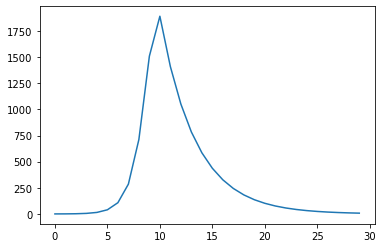

In [12]:
pure_increase_in_I_1 = sum((simulation_population_1[1]*Gammas).T)
plt.plot(pure_increase_in_I_1[0:30])

# 2nd wave

Simulation parameters

In [13]:
Lambda = [0.1, 0.1]     # Infection rate 0.02 ~ 0.6
Gamma = [1/7, 1/14]      # Exposed to infected rate 1/14 ~ 1/5
Sigma_E = [1/7, 1/5]     # Recovery rate for exposed 1/14
Sigma_I = [1/14, 1/7]     # Cured rate for infected 1/20 ~ 1/10
Delta = [0.01, 0.001]   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i_original = [0.5, 0.5]       # proportion corresponding to sensitivity clan

c_j_original = [15, 10]             # contact rates for different social activity level group
p_j_original = [0.25, 0.75]        # proportion corresponding to contact rates

T = 100        # Terminal time in week

S_initial = 150000    # Initial number of susceptible
R_initial = 0         # Initial number of recovered from E
I_initial = 0         # Initial number of infected 
C_initial = 0         # Initial number of recovered from R
D_initial = 0         # Initial number of Death

E_proportion = 0.0001
E_initial = S_initial * E_proportion        # Initial number of exposed

sensitivity_num = len(p_i_original)
contact_num = len(p_j_original)
    
division_num = sensitivity_num * contact_num     # number of divisions
c_j = np.zeros(division_num)          # contact rate
p= np.zeros(division_num)   # proportion of each division
Lambdas = np.zeros(division_num)          # lamda, Infection rate
Gammas = np.zeros(division_num)          # gamma, Exposed to infected rate
Sigma_Es = np.zeros(division_num)          # sigma_E, Recovery rate for exposed
Sigma_Is = np.zeros(division_num)          # sigma_I, Cured rate for infected
Deltas = np.zeros(division_num)          # delta, death rate (case fatality rate)


p_i = 0 # proportion for sensitivity, not used in simulation
p_j = 0 # proportion for contact rate, not used in simulation

for j in range(0,len(p_j_original)):
    for i in range(0,len(p_i_original)):
        c_j[(j)*sensitivity_num+i] = c_j_original[j]
        p[(j)*sensitivity_num+i] = p_j_original[j]*p_i_original[i]
        Lambdas[(j)*sensitivity_num+i] = Lambda[i]
        Gammas[(j)*sensitivity_num+i] = Gamma[i]
        Sigma_Es[(j)*sensitivity_num+i] = Sigma_E[i]
        Sigma_Is[(j)*sensitivity_num+i] = Sigma_I[i]
        Deltas[(j)*sensitivity_num+i] = Delta[i]
    # end for i
# end for j

S_0 = S_initial * p
E_0 = E_initial * p
R_0 = R_initial * p
I_0 = I_initial * p
C_0 = C_initial * p
D_0 = D_initial * p

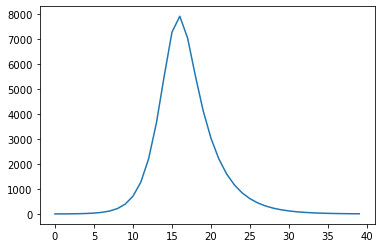

In [14]:
simulation_population_2 = SEIR_simulation_division(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 0,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_by_division # output order: S, E, R, I, C, D, Cumulated_V
    )

# Plot
pure_increase_in_I_2 = sum((simulation_population_2[1]*Gammas).T)
plt.plot(pure_increase_in_I_2[0:40])

# 3rd wave

In [15]:
Lambda = [0.1, 0.1]     # Infection rate 0.02 ~ 0.6
Gamma = [1/10, 1/14]      # Exposed to infected rate 1/14 ~ 1/5
Sigma_E = [1/7, 1/5]     # Recovery rate for exposed 1/14
Sigma_I = [1/14, 1/7]     # Cured rate for infected 1/20 ~ 1/10
Delta = [0.01, 0.001]   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i_original = [0.5, 0.5]       # proportion corresponding to sensitivity clan

c_j_original = [10, 5]             # contact rates for different social activity level group
p_j_original = [0.5, 0.5]        # proportion corresponding to contact rates

T = 50        # Terminal time in week

S_initial = 100000    # Initial number of susceptible
R_initial = 0         # Initial number of recovered from E
I_initial = 0         # Initial number of infected 
C_initial = 0         # Initial number of recovered from R
D_initial = 0         # Initial number of Death

E_proportion = 0.0001
E_initial = S_initial * E_proportion        # Initial number of exposed

sensitivity_num = len(p_i_original)
contact_num = len(p_j_original)
    
division_num = sensitivity_num * contact_num     # number of divisions
c_j = np.zeros(division_num)          # contact rate
p= np.zeros(division_num)   # proportion of each division
Lambdas = np.zeros(division_num)          # lamda, Infection rate
Gammas = np.zeros(division_num)          # gamma, Exposed to infected rate
Sigma_Es = np.zeros(division_num)          # sigma_E, Recovery rate for exposed
Sigma_Is = np.zeros(division_num)          # sigma_I, Cured rate for infected
Deltas = np.zeros(division_num)          # delta, death rate (case fatality rate)


p_i = 0 # proportion for sensitivity, not used in simulation
p_j = 0 # proportion for contact rate, not used in simulation

for j in range(0,len(p_j_original)):
    for i in range(0,len(p_i_original)):
        c_j[(j)*sensitivity_num+i] = c_j_original[j]
        p[(j)*sensitivity_num+i] = p_j_original[j]*p_i_original[i]
        Lambdas[(j)*sensitivity_num+i] = Lambda[i]
        Gammas[(j)*sensitivity_num+i] = Gamma[i]
        Sigma_Es[(j)*sensitivity_num+i] = Sigma_E[i]
        Sigma_Is[(j)*sensitivity_num+i] = Sigma_I[i]
        Deltas[(j)*sensitivity_num+i] = Delta[i]
    # end for i
# end for j

S_0 = S_initial * p
E_0 = E_initial * p
R_0 = R_initial * p
I_0 = I_initial * p
C_0 = C_initial * p
D_0 = D_initial * p

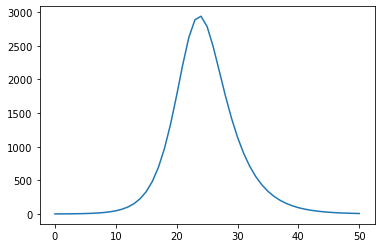

In [16]:
simulation_population_3 = SEIR_simulation_division(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 0,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_by_division # output order: S, E, R, I, C, D, Cumulated_V
    )

# Plot
pure_increase_in_I_3 = sum((simulation_population_3[1]*Gammas).T)
plt.plot(pure_increase_in_I_3)

Start time for 3 waves

In [17]:
t_1 = 0  # May
t_2 = 16 # September
t_3 = 25 # November
t_1, t_2, t_3

(0, 16, 25)

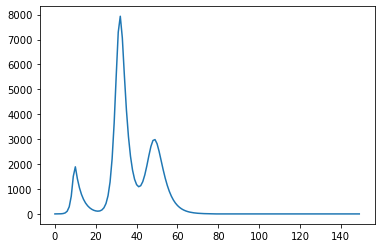

In [18]:
pure_increase_in_I = np.zeros(150)
for t in range(len(pure_increase_in_I_1)):
    pure_increase_in_I[t_1+t] += pure_increase_in_I_1[t]
    
for t in range(len(pure_increase_in_I_2)):
    pure_increase_in_I[t_2+t] += pure_increase_in_I_2[t]
    
for t in range(len(pure_increase_in_I_3)):
    pure_increase_in_I[t_3+t] += pure_increase_in_I_3[t]
    
plt.plot(pure_increase_in_I)

# Old SEIR model prediction

1st wave

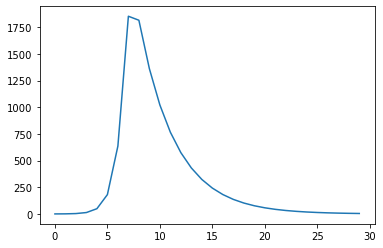

In [19]:
Lambdas = 0.0001     # Infection rate 0.02 ~ 0.6
Gammas = 1/12      # Exposed to infected rate 1/14 ~ 1/5
Sigma_Es = 1/6     # Recovery rate for exposed 1/14
Sigma_Is = 1/10     # Cured rate for infected 1/20 ~ 1/10
Deltas = 0.01   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i = 0.5      # proportion corresponding to sensitivity clan

c_j = 20            # contact rates for different social activity level group
p_j = 0.5        # proportion corresponding to contact rates

T = 100        # Terminal time in week

S_0 = 30000    # Initial number of susceptible
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death

E_proportion = 0.0001
E_0 = S_0 * E_proportion        # Initial number of exposed

coverage_time = 100 # in weeks
v_epsilon = 0.9

simulation_population_1_old = SEIR_old_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 0,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_by_division # output order: S, E, R, I, C, D, Cumulated_V
    )

pure_increase_in_I_1_old = simulation_population_1_old[1]*Gammas
plt.plot(pure_increase_in_I_1_old[0:30])

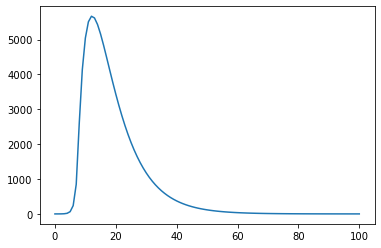

In [20]:
plt.plot(simulation_population_1_old[3])

2nd wave

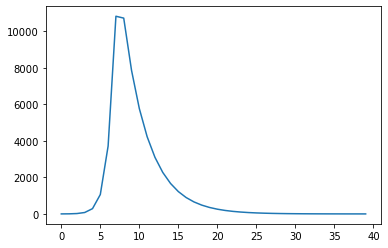

In [21]:
Lambdas = 0.00002     # Infection rate 0.02 ~ 0.6
Gammas = 1/10      # Exposed to infected rate 1/14 ~ 1/5
Sigma_Es = 1/6     # Recovery rate for exposed 1/14
Sigma_Is = 1/10     # Cured rate for infected 1/20 ~ 1/10
Deltas = 0.01   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i = 1      # proportion corresponding to sensitivity clan

c_j = 12             # contact rates for different social activity level group
p_j = 1        # proportion corresponding to contact rates

T = 100        # Terminal time in week

S_0 = 150000    # Initial number of susceptible
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death

E_proportion = 0.0001
E_0 = S_0 * E_proportion        # Initial number of exposed

coverage_time = 100 # in weeks
v_epsilon = 0.9

simulation_population_2_old = SEIR_old_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 0,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_by_division # output order: S, E, R, I, C, D, Cumulated_V
    )

# Plot
pure_increase_in_I_2_old = simulation_population_2_old[1]*Gammas
plt.plot(pure_increase_in_I_2_old[0:40])

3rd wave

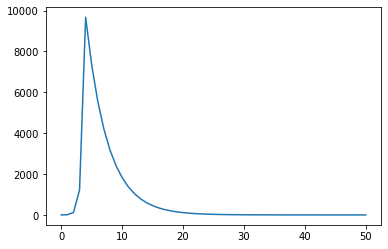

In [22]:
Lambdas = 0.0001     # Infection rate 0.02 ~ 0.6
Gammas = 1/10      # Exposed to infected rate 1/14 ~ 1/5
Sigma_Es = 1/7     # Recovery rate for exposed 1/14
Sigma_Is = 1/14     # Cured rate for infected 1/20 ~ 1/10
Deltas = 0.01  # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i = 1       # proportion corresponding to sensitivity clan

c_j = 10             # contact rates for different social activity level group
p_j = 1        # proportion corresponding to contact rates

T = 50        # Terminal time in week

S_0 = 100000    # Initial number of susceptible
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death

E_proportion = 0.0001
E_0 = S_0 * E_proportion        # Initial number of exposed


simulation_population_3_old = SEIR_old_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (1st part need to change before running)
    vaccination_strategy        = no_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = 0,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_by_division # output order: S, E, R, I, C, D, Cumulated_V
    )

# Plot
pure_increase_in_I_3_old = simulation_population_3_old[1]*Gammas
plt.plot(pure_increase_in_I_3_old)

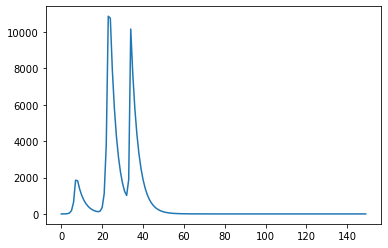

In [23]:
pure_increase_in_I_old = np.zeros(150)
for t in range(len(pure_increase_in_I_1_old)):
    pure_increase_in_I_old[t_1+t] += pure_increase_in_I_1_old[t]
    
for t in range(len(pure_increase_in_I_2)):
    pure_increase_in_I_old[t_2+t] += pure_increase_in_I_2_old[t]
    
for t in range(len(pure_increase_in_I_3)):
    pure_increase_in_I_old[30+t] += pure_increase_in_I_3_old[t]
    
plt.plot(pure_increase_in_I_old)

# Import real data confirmed cases

In [24]:
confirm_I_df = pd.read_csv ('covid_confirmed_usafacts.csv')
confirm_I_df.T

,0,1,2
2020/2/1,0.0,0.0,0.000000
2020/2/2,0.0,0.0,0.000000
2020/2/3,0.0,0.0,0.000000
2020/2/4,0.0,0.0,0.000000
2020/2/5,0.0,0.0,0.000000
...,...,...,...
2021/6/26,101854.0,10.0,14.285714
2021/6/27,101864.0,7.0,13.000000
2021/6/28,101871.0,15.0,13.000000
2021/6/29,101886.0,12.0,13.857143


In [25]:
daily_I = confirm_I_df.values.tolist()[1]
average_I = confirm_I_df.values.tolist()[2]
len(daily_I), len(average_I)

(516, 516)

In [26]:
start_idx = 88
confirm_I_df.T.iloc[start_idx]

0    1273.0
1      16.0
2      20.0
Name: 2020/4/29, dtype: float64

In [27]:
end_idx = 515
confirm_I_df.T.iloc[end_idx]

0    101898.000000
1        11.000000
2        12.571429
Name: 2021/6/30, dtype: float64

427

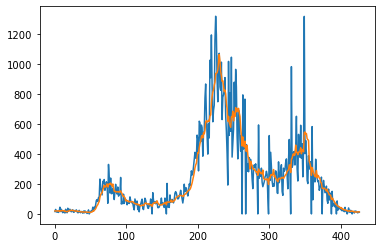

In [28]:
selected_daily_I = daily_I[start_idx:end_idx]
selected_average_I = average_I[start_idx:end_idx]

plt.plot(daily_I[start_idx:end_idx])
plt.plot(average_I[start_idx:end_idx])

len(selected_daily_I)

# Weekly comfirmed cases

In [29]:
weekly_I = np.zeros(int(len(selected_daily_I)/7))

for t in range(len(weekly_I)):
    weekly_I[t] = sum(selected_daily_I[t*7:t*7+6])
len(weekly_I)

61

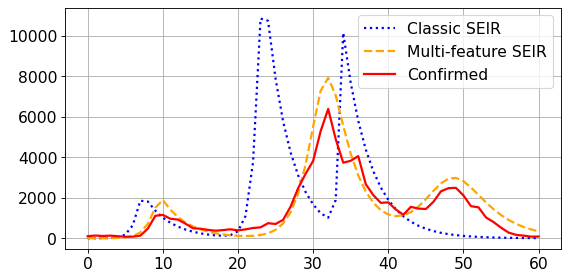

In [33]:
figure(figsize = (8,4), dpi = 80)
plt.plot(pure_increase_in_I_old[0:len(weekly_I)], label="Classic SEIR", color="blue", linewidth=2, linestyle=':')
plt.plot(pure_increase_in_I[0:len(weekly_I)], label="Multi-feature SEIR", color="orange", linewidth=2, linestyle='--')
plt.plot(weekly_I, label="Confirmed", color="red", linewidth=2)
plt.legend(loc = 'upper right', prop = {'size':14})
plt.grid()
plt.tick_params(labelsize=14)

In [123]:
sum(pure_increase_in_I[0:len(weekly_I)])/sum(weekly_I)

1.161391960856357